In [110]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.mixture import GaussianMixture

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import parall_accuracy
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

# Step 1. Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 –target variables, the rest - predictors).

In [2]:
df = pd.read_csv(r'C:\Users\79697\Desktop\MSFT.csv')
target = ['Close(t)', 'DJIA_Close', 'SnP_Close']
predictors = ['MA10', 'SD20', 'MACD', 'ATR', 'QQQ_Close', 'QQQ_MA10', 'Close_forcast']

<AxesSubplot:>

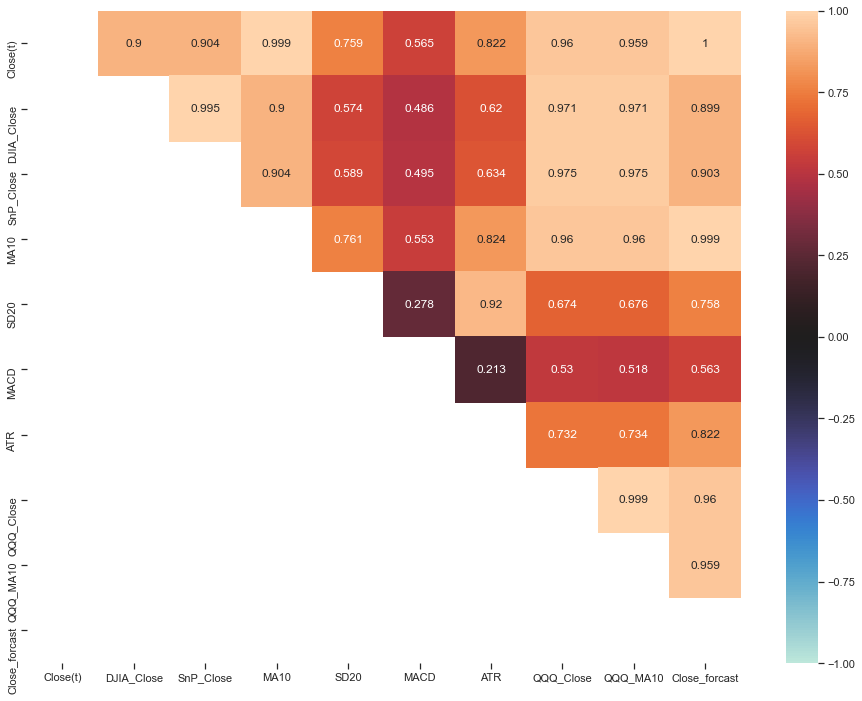

In [289]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
corr_matrix = df[target + predictors].corr()
matrix = np.tril(corr_matrix)
sns.heatmap(corr_matrix, annot = True, fmt='.3g', vmin=-1, vmax=1, center= 0, mask = matrix)

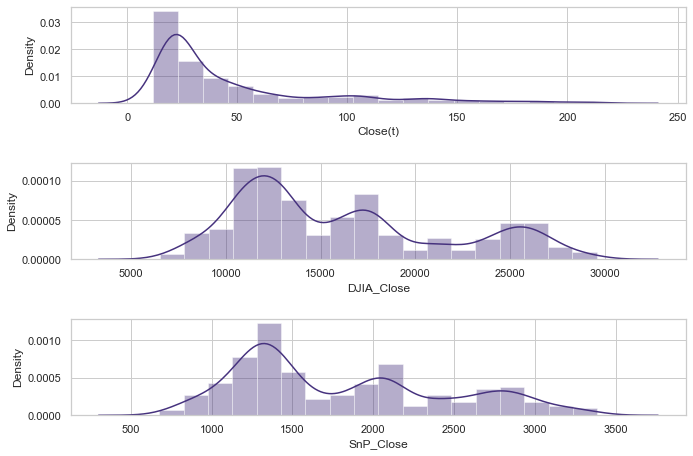

In [4]:
sns.set_theme(style="whitegrid", palette="viridis")
fig, axs = plt.subplots(3, 1, figsize=(10, 7), squeeze=False)
fig.tight_layout(pad=3.0)
axs = axs.flat

for num, col in enumerate(target):
    sns.distplot(df[col], kde=True, norm_hist=True, bins=18, ax=axs[num])

## 1.1. Theoretical distribution of sample

In [480]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        dist_name = distribution
        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                
                sse = np.sum(np.power(y - pdf, 2.0))
                
                check_pvalue = True
                check_plot = True
                #'''
                try:
                    ks1 = st.kstest(y, distribution.cdf, params)
                    ks2 = st.cramervonmises(y, distribution.cdf, params)
                                   
                    if ks1.pvalue > 0.05 or ks2.pvalue > 0.05:
                        #print(ii, dist_name, sse, ks1.pvalue, ks2.pvalue)
                        check_pvalue = True
                        
                        
                except Exception:
                    print(ii, dist_name, 'Error')
                #'''
                
                # if axis pass in add to plot
                try:
                    if ax and check_pvalue:
                        pd.Series(pdf, x).plot(ax=ax)
                        check_plot = True
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if check_pvalue and check_plot:
                    best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass
    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [125]:
def plot_pdf(data, var, bins = 200):
    # Load data from statsmodels datasets
    data = data[var]

    # Plot for comparison
    plt.figure(figsize=(12,8))
    ax = data.plot(kind='hist', bins=18, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

    # Save plot limits
    dataYLim = ax.get_ylim()

    # Find best fit distribution
    best_distibutions = best_fit_distribution(data, bins, ax)
    if (len(best_distibutions) != 0 ):
        best_dist = best_distibutions[0]

        # Update plots
        ax.set_ylim(dataYLim)
        ax.set_title(u'All Fitted Distributions')

        # Make PDF with best params 
        pdf = make_pdf(best_dist[0], best_dist[1])

        # Display
        plt.figure(figsize=(12,8))
        ax = pdf.plot(lw=2, label='PDF', legend=True)
        data.plot(kind='hist', bins=18, density=True, alpha=0.5, label='Data', legend=True, ax=ax)
    
        param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
        param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
        dist_str = '{}({})'.format(best_dist[0].name, param_str)

        ax.set_title(u'Best fit distribution \n' + dist_str)
        ax.set_xlabel(f'{var}')
        ax.set_ylabel('Frequency')
    

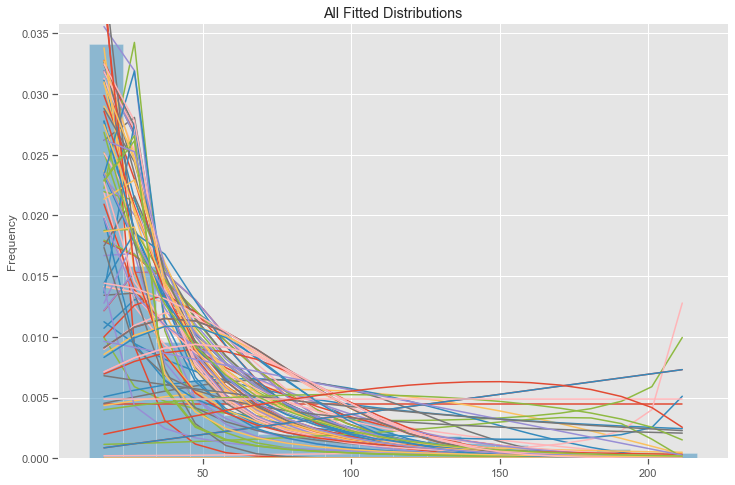

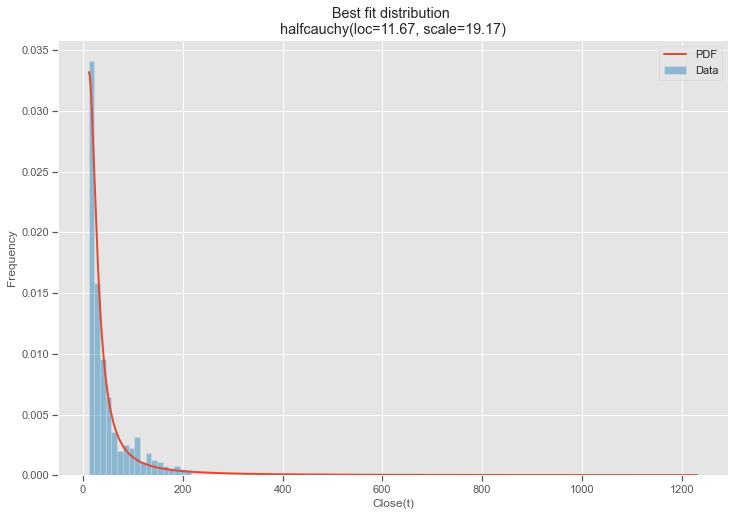

In [126]:
plot_pdf(df, 'Close(t)', 20)

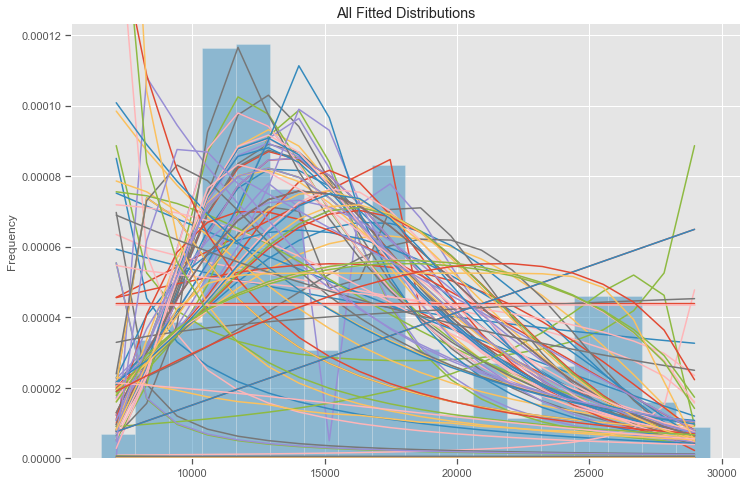

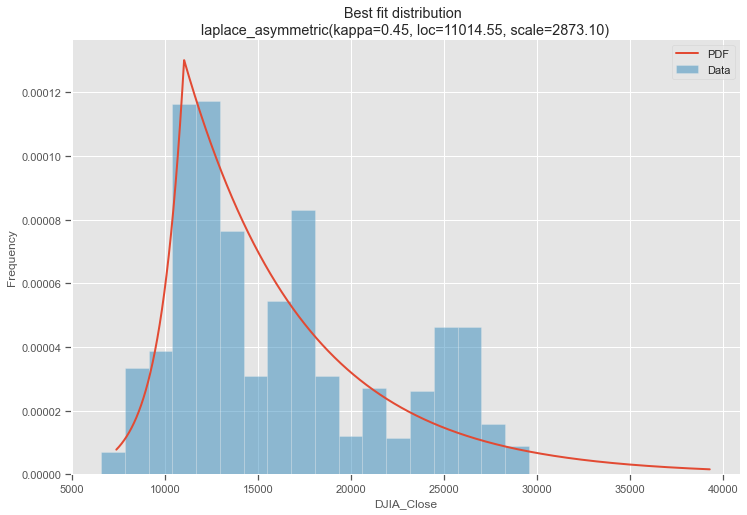

In [127]:
plot_pdf(df, 'DJIA_Close', 20)

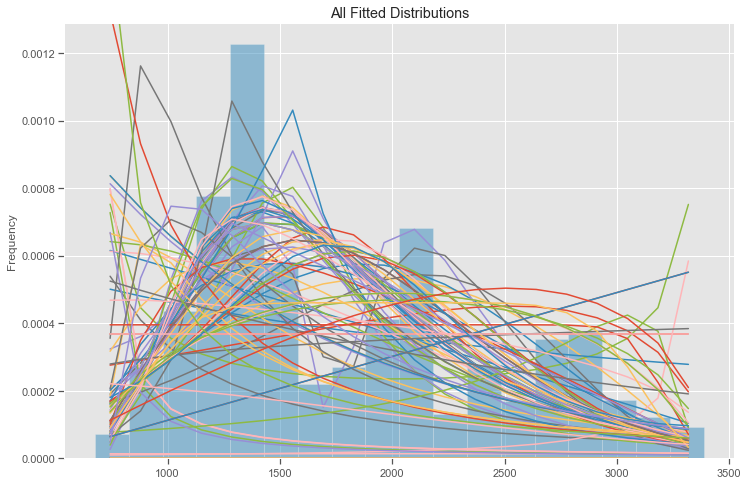

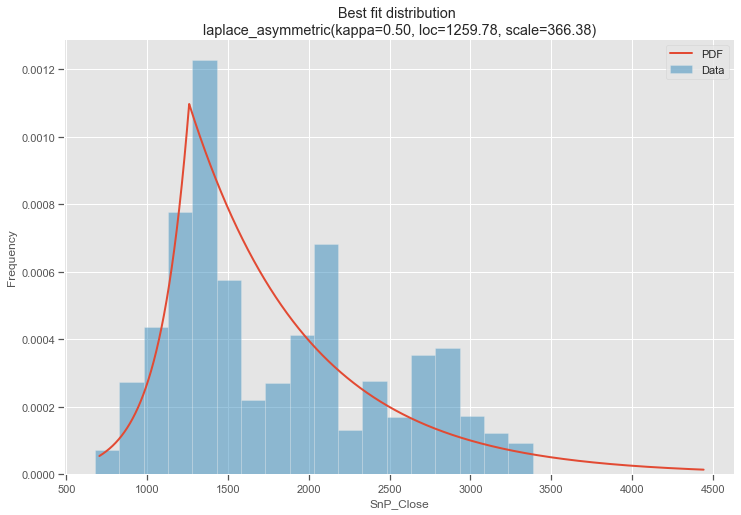

In [128]:
plot_pdf(df, 'SnP_Close', 20)

In [255]:
def qq_biplot(data, var, distr, params):
    
    min_val, max_val = data[var].min(), data[var].max()
    x = np.linspace(min_val, max_val, num=100)

    # Quantiles calculation
    percs = np.linspace(0, 100, num=100)
    qn_first = np.percentile(data[var], percs)
    qn_distr = getattr(st, distr).ppf(percs / 100.0, *params)

    #Biplot
    plt.figure(figsize=(10,10))
    plt.plot(qn_first, qn_distr, ls="", marker="o", markersize=3)
    plt.plot(x, x, color="k", ls="--")
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.xlabel(f'Empirical distribution of {var}' )
    plt.ylabel(f'{distr} theoretical distribution of {var}')
    plt.show()

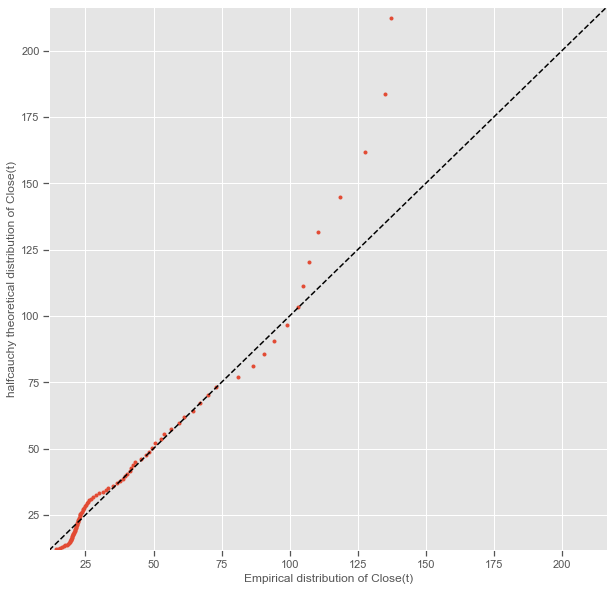

In [256]:
qq_biplot(df, 'Close(t)', 'halfcauchy', st.halfcauchy.fit(df['Close(t)']))

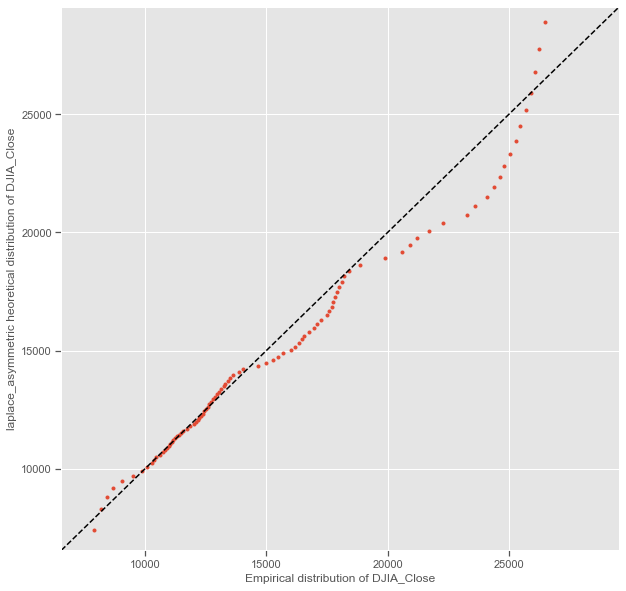

In [253]:
qq_biplot(df, 'DJIA_Close', 'laplace_asymmetric', st.laplace_asymmetric.fit(df['DJIA_Close']))

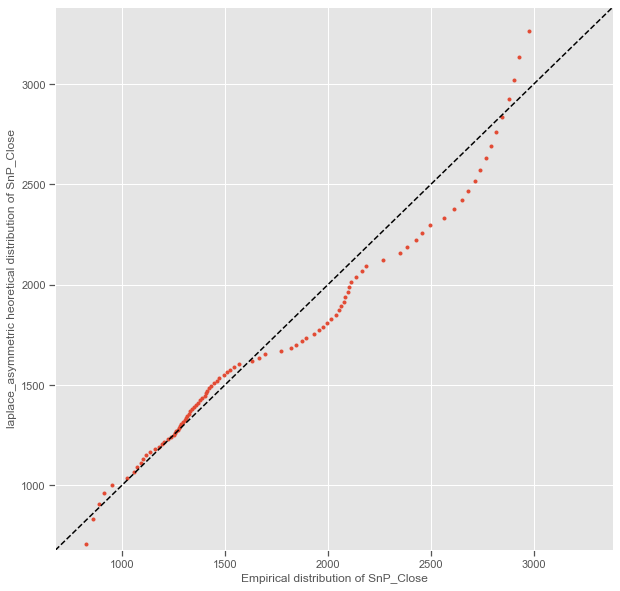

In [254]:
qq_biplot(df, 'SnP_Close', 'laplace_asymmetric', st.laplace_asymmetric.fit(df['SnP_Close']))

In [502]:
def gm_plot(data, var, n_comp, n_bins = 20, n_samples = 10000):
    gm = GaussianMixture(n_components=n_comp).fit(data[[var]])
    dist = sns.distplot(data[var], kde = False, norm_hist = True, bins = n_bins, label = f'Actual Data', color = 'skyblue')
    plt.ylabel(f'Frequency')
    plt.xlabel(f'{var}')
    
    x = np.linspace(df[var].min(), df[var].max(), n_samples)
    estims = []
    estim_cdf = []
    for n in range(gm.n_components):
        estim = st.norm.pdf(x, gm.means_[n], np.sqrt(gm.covariances_[n])) * gm.weights_[n]
        cdf = st.norm.cdf(x, gm.means_[n], np.sqrt(gm.covariances_[n])) * gm.weights_[n]
        dist.plot(x, estim[0])
        estims.append(estim[0])
        estim_cdf.append(cdf[0])
        
    dist.plot(x, np.sum(estims, axis=0), label='Sum of Gaussian components', color = 'red')
    dist.legend()
    
    
    return x, np.sum(estims, axis=0), np.sum(estim_cdf, axis=0), gm

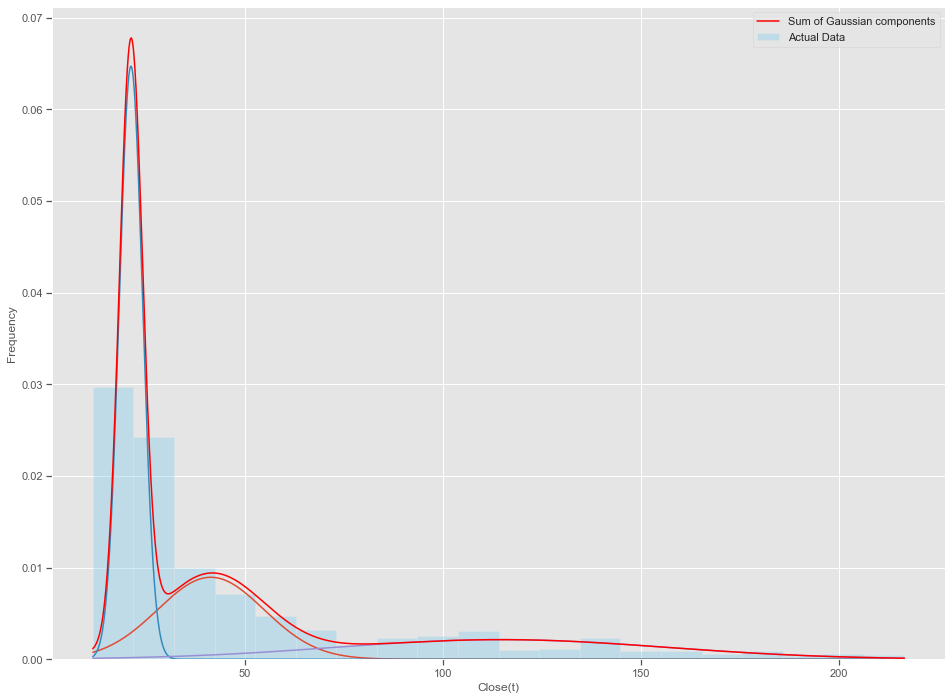

In [503]:
close_d = gm_plot(df, 'Close(t)', 3)

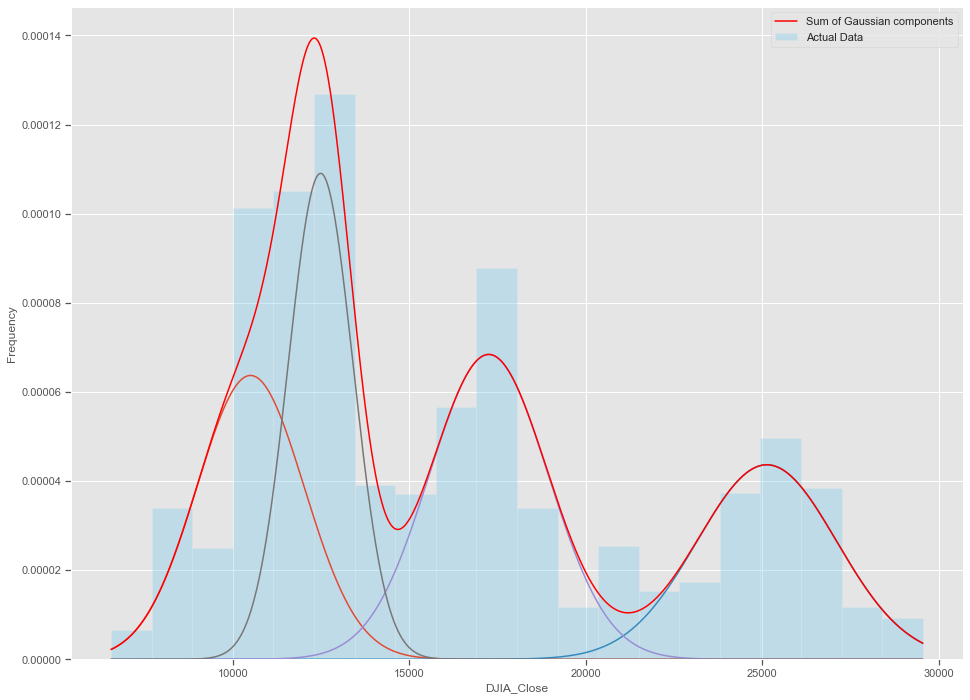

In [504]:
dj_d = gm_plot(df, 'DJIA_Close', 4)

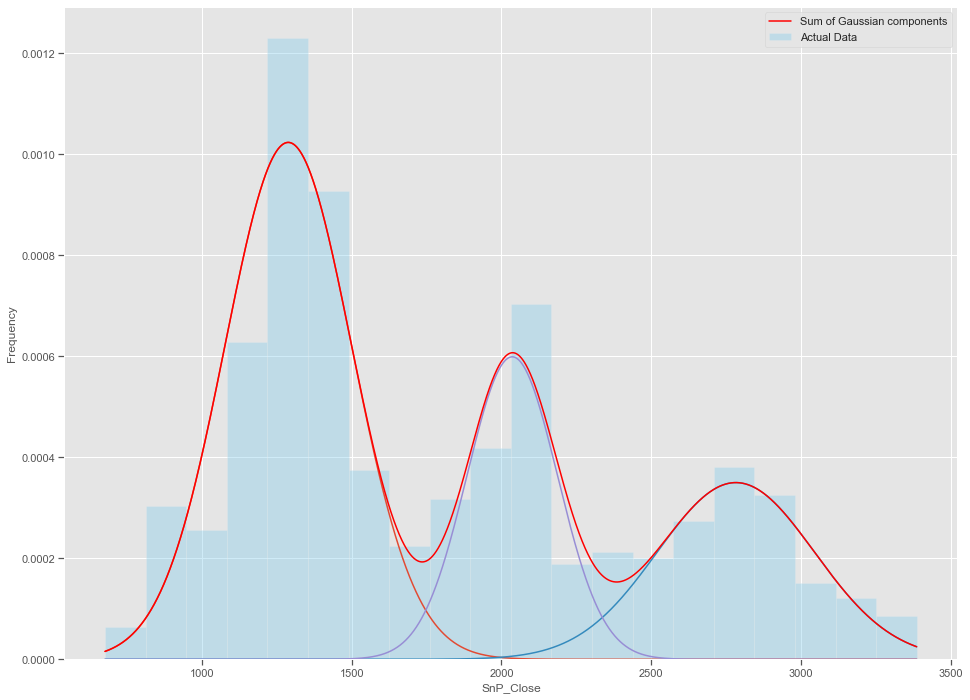

In [505]:
snp_d = gm_plot(df, 'SnP_Close', 3)

In [485]:
def inverse_transform_sampling(data, var, x, y, n_bins = 40, n_samples=1000):
    data = data[var]
    inv_cdf = interpolate.interp1d(y, x)
    
    r = np.random.rand(n_samples)
    r = list(map(lambda x: x if x <= y.max() and x >= y.min() 
             else y.min() if x < y.min() else y.max(), r))
    
    gen_data = inv_cdf(r)
    plt.figure(figsize=(12,9))
    
    sns.distplot(gen_data, kde=True, norm_hist=True, bins=n_bins, label="Generated data")
    sns.distplot(data, kde=True, norm_hist=True, bins=n_bins, label="Actual data")
    
    plt.title(f"Generated vs Actual Data of {var} variable")
    
    plt.xlabel(f'{var}')
    plt.ylabel('Frequency')
    
    plt.legend()
    plt.show()
    

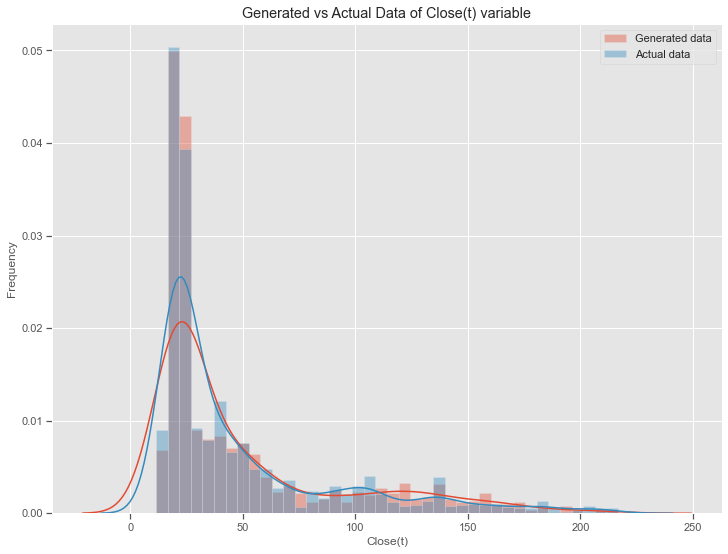

In [486]:
inverse_transform_sampling(df, "Close(t)", close_d[0], close_d[2])

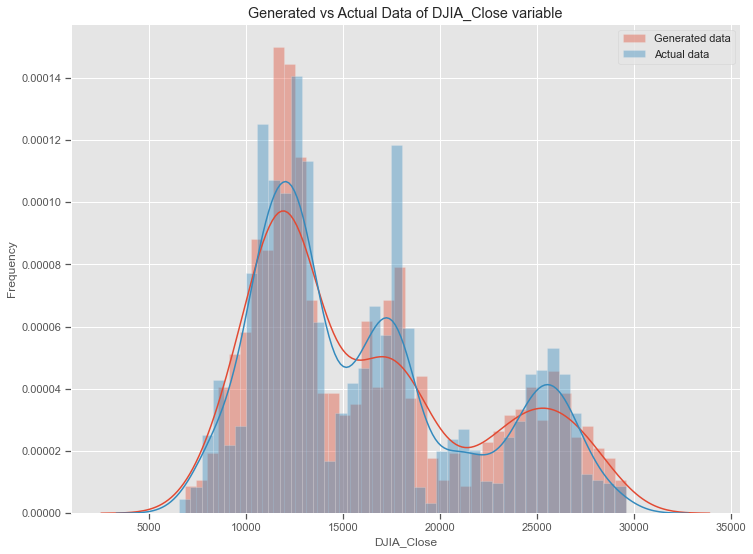

In [487]:
inverse_transform_sampling(df, "DJIA_Close", dj_d[0], dj_d[2])

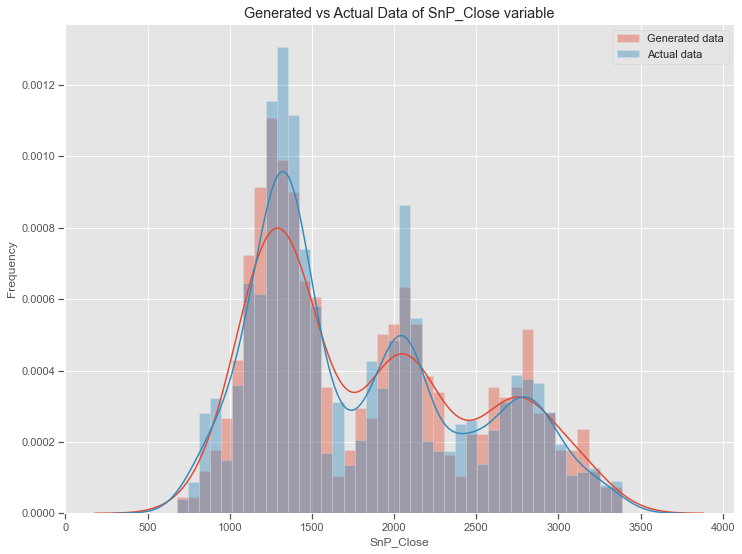

In [488]:
inverse_transform_sampling(df, "SnP_Close", snp_d[0], snp_d[2])

# Step 2. Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

## 2.1. Inverse Transform Sampling Part I (Calculation Inverse CDF)

In [489]:
def inverse_transform_sampling(data, var, th_dist, n_bins = 40, n_samples=1000):
    data = data[var]
    
    x = np.random.rand(n_samples)
    params = th_dist.fit(data)
    
    gen_func = th_dist(*params)
    gen_data = gen_func.ppf(x)
    print('ppf')
    
    plt.figure(figsize=(12,9))
    
    sns.distplot(gen_data, kde=True, norm_hist=True, bins=n_bins, label="Generated data")
    sns.distplot(data, kde=True, norm_hist=True, bins=n_bins, label="Actual data")
    
    plt.title(f"Generated vs Actual Data of {var} variable")
    
    plt.xlabel(f'{var}')
    plt.ylabel('Frequency')
    
    plt.legend()
    plt.show()
    
    

ppf


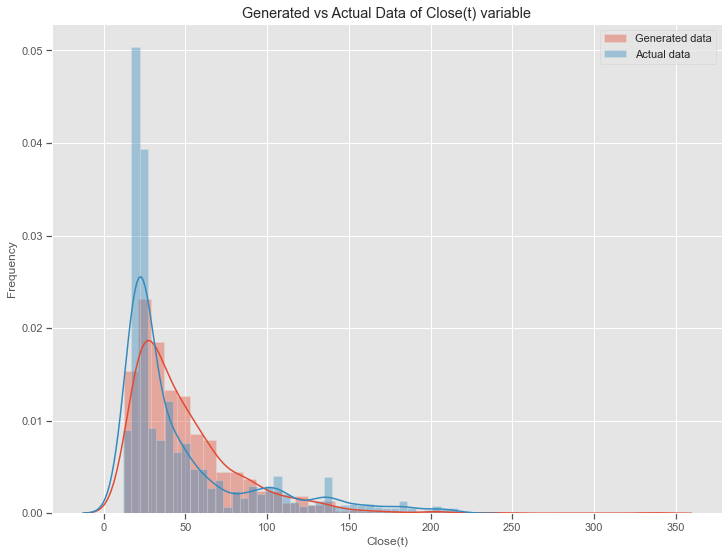

In [490]:
inverse_transform_sampling(df, 'Close(t)', st.exponnorm, n_samples = 1000)

ppf


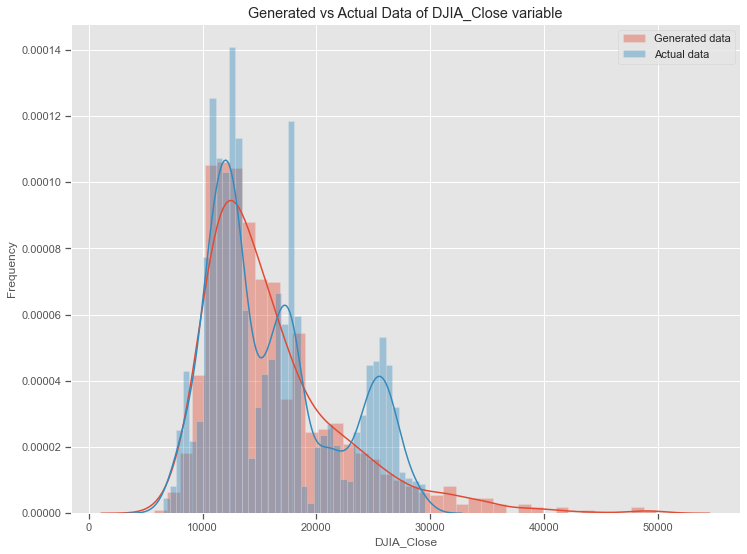

In [491]:
inverse_transform_sampling(df, 'DJIA_Close', st.laplace_asymmetric, n_samples = 1000)

ppf


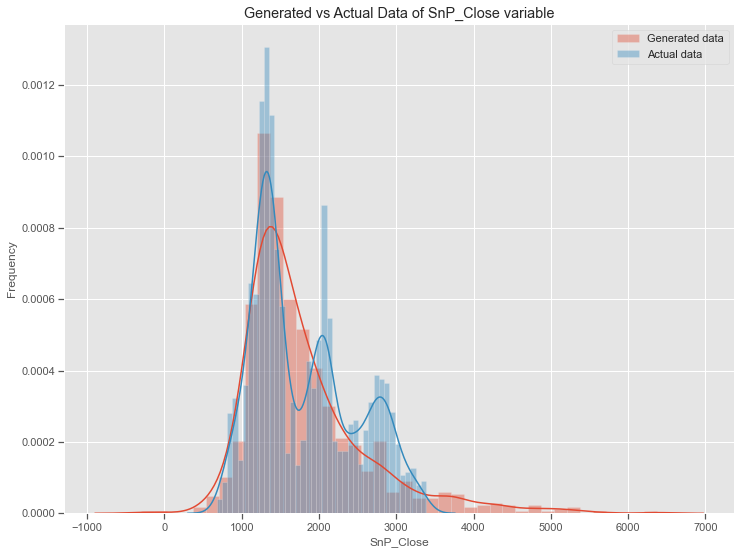

In [492]:
inverse_transform_sampling(df, 'SnP_Close', st.laplace_asymmetric, n_samples = 1000)

## 2.1.2. Inverse Transform Sampling Part II (Interpolation Inverse CDF)

In [280]:
import scipy.interpolate as interpolate

def inverse_transform_sampling_(data, var, n_bins=40, n_samples=1000):
    data = data[var]
    hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    gen_data = inv_cdf(r)
    
    plt.figure(figsize=(12,9))
    
    sns.distplot(gen_data, kde=True, norm_hist=True, bins=n_bins, label="Generated data")
    sns.distplot(data, kde=True, norm_hist=True, bins=n_bins, label="Actual data")
    
    plt.title(f"Generated vs Actual Data of {var} variable")
    
    plt.xlabel(f'{var}')
    plt.ylabel('Frequency')
    
    plt.legend()
    plt.show()
    
    return inv_cdf(r)

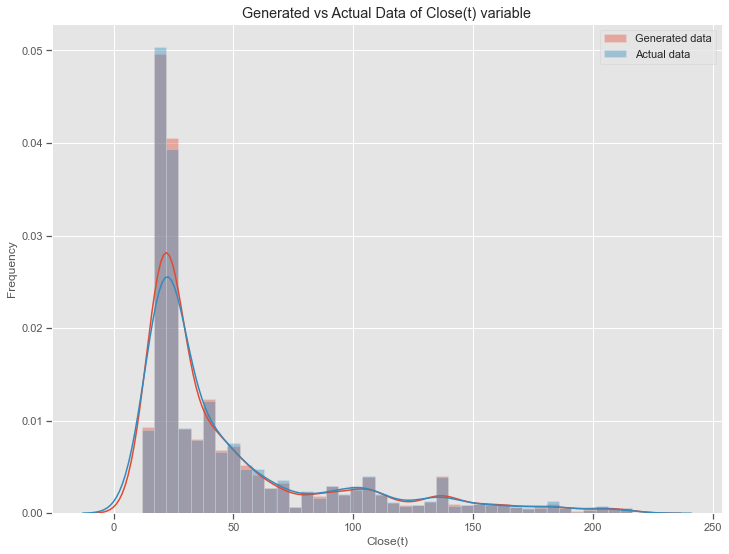

array([25.40236827, 54.71831818, 53.86522813, ..., 23.32422277,
       17.77906039, 30.49283042])

In [281]:
inverse_transform_sampling_(df, 'Close(t)', n_samples=10000)

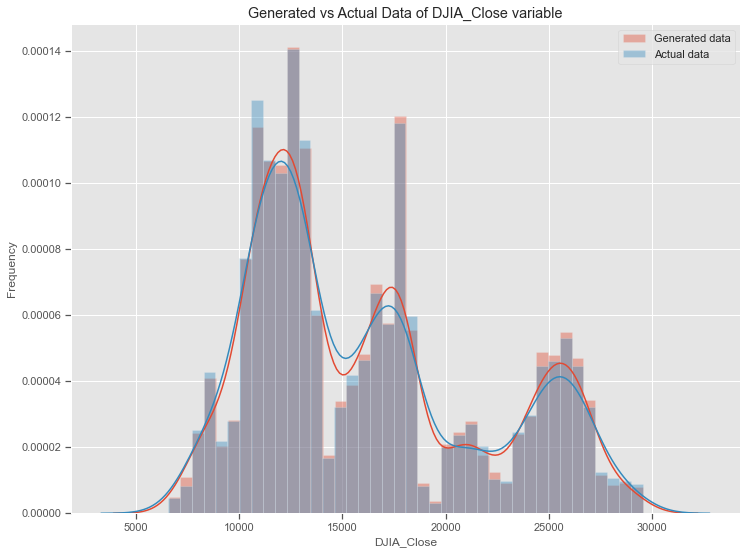

array([16676.01955161, 15726.69661851, 11670.8168436 , ...,
       17861.14399569, 16917.04172767, 11282.98708474])

In [282]:
inverse_transform_sampling_(df, 'DJIA_Close', n_samples=10000)

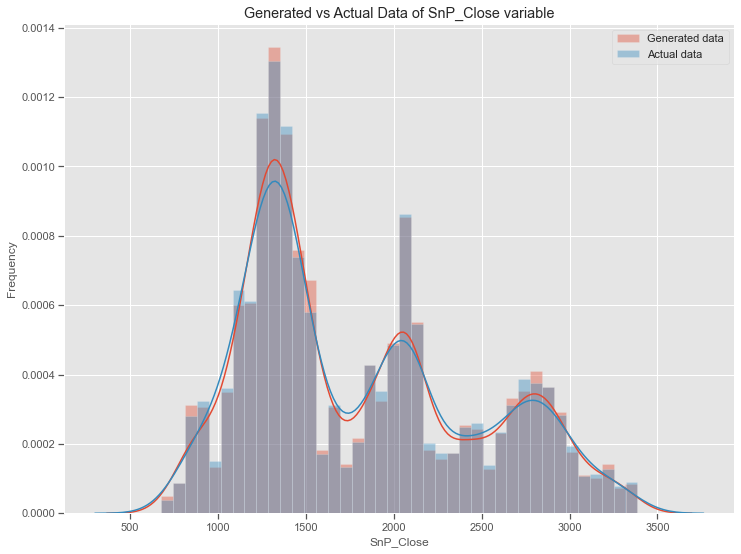

array([1229.19562035, 2559.66817971, 1704.7235671 , ..., 1127.14581956,
       1213.85630935, 1440.77747875])

In [283]:
inverse_transform_sampling_(df, 'SnP_Close', n_samples=10000)

## 2.2. Accept-Reject sampling

In [23]:
def accept_rejection_sampling(data, var, k, function, function_, *params):
    y, x = np.histogram(data[var], bins=18, density=True)
    X = np.linspace(data[var].min(), data[var].max(), 1000)
    
    n = 100000
    samples = []
    for i in range(n):
        s = function_(*params)
        position = -1
        for p in range(1, len(x)-1):
            if s < x[p]:
                position = p-1
                break
        prob_accept = y[p]/(k*function(s, *params))
        
        if np.random.random() < prob_accept and s >= X[0] and s <= X[len(X)-1]:
            samples.append(s)

    x = np.linspace(data[var].min(), data[var].max(), 1000)
    y = k*function(x, *params)
    
    
    plt.figure(figsize=(12,9))
    plt.plot(x, y, label = 'k*g(x)')
    
    plt.hist(data[var], bins=18, alpha=0.5, label="Actual data", density = True)
    plt.hist(samples, bins=18, alpha=0.5, label="Generated data", density = True)
    plt.title(f"Generated vs Actual Data of {var} variable")

    plt.legend()
    plt.show()

In [24]:
from scipy.special import beta
def exp(x, l):
    return (1/l)*np.exp(-(1/l)*x)

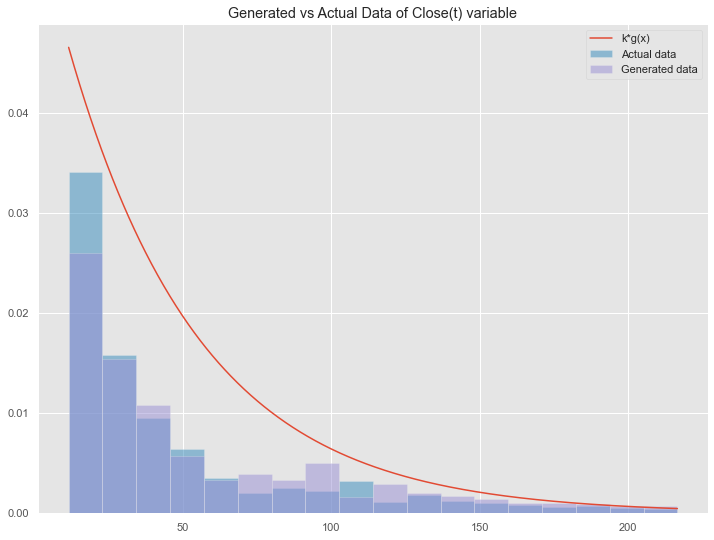

In [25]:
accept_rejection_sampling(df, 'Close(t)', 2.7, exp, np.random.exponential, 1/0.0224)

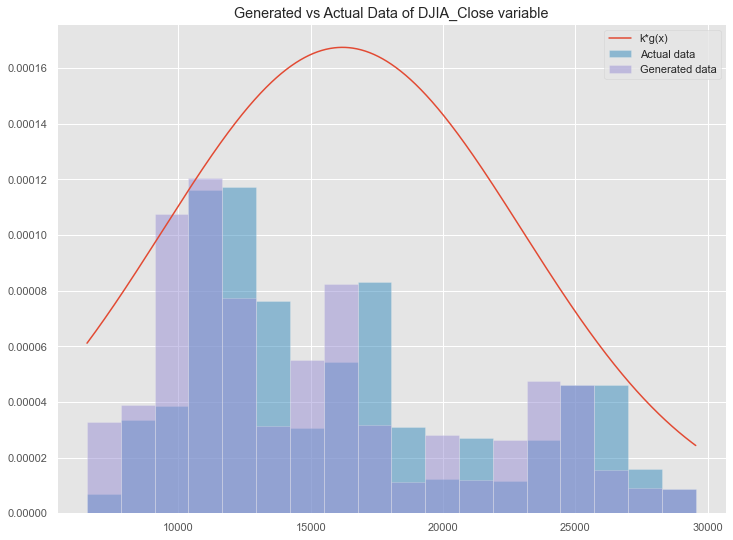

In [26]:
accept_rejection_sampling(df, 'DJIA_Close', 2.855, st.norm.pdf, st.norm.rvs, 
                          *[16200, 6800])

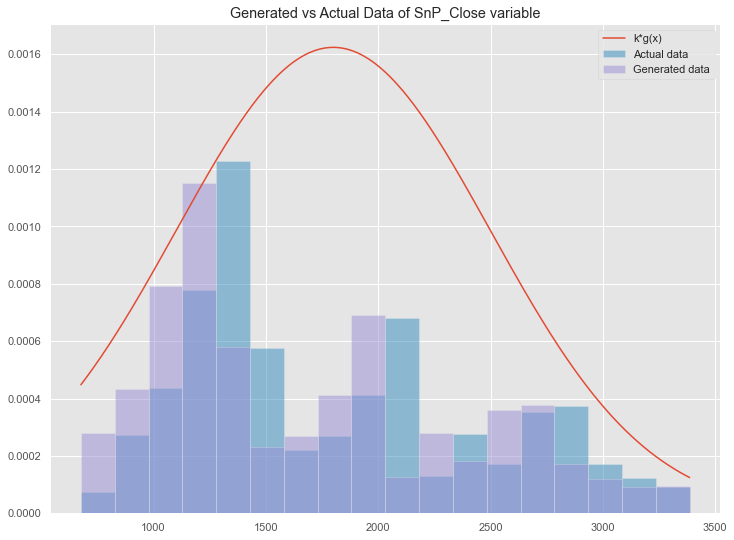

In [27]:
accept_rejection_sampling(df, 'SnP_Close', 2.85, st.norm.pdf, st.norm.rvs, 
                          *[1800, 700])

# Step 3. Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

In [72]:
corr_matrix

,Close(t),DJIA_Close,SnP_Close,MA10,SD20,MACD,ATR,QQQ_Close,QQQ_MA10,Close_forcast
Close(t),1.000000,0.899848,0.903968,0.999256,0.759053,0.564990,0.821895,0.960307,0.959055,0.999536
DJIA_Close,0.899848,1.000000,0.994680,0.899719,0.574057,0.485529,0.620455,0.970927,0.970854,0.899307
SnP_Close,0.903968,0.994680,1.000000,0.903746,0.589050,0.495334,0.634480,0.975022,0.974707,0.903452
MA10,0.999256,0.899719,0.903746,1.000000,0.761010,0.553203,0.824434,0.959997,0.959989,0.999009
SD20,0.759053,0.574057,0.589050,0.761010,1.000000,0.278019,0.919613,0.673921,0.676373,0.758396
MACD,0.564990,0.485529,0.495334,0.553203,0.278019,1.000000,0.212649,0.530341,0.517976,0.563327
ATR,0.821895,0.620455,0.634480,0.824434,0.919613,0.212649,1.000000,0.731885,0.734116,0.821970
QQQ_Close,0.960307,0.970927,0.975022,0.959997,0.673921,0.530341,0.731885,1.000000,0.999265,0.959901
QQQ_MA10,0.959055,0.970854,0.974707,0.959989,0.676373,0.517976,0.734116,0.999265,1.000000,0.958802
Close_forcast,0.999536,0.899307,0.903452,0.999009,0.758396,0.563327,0.821970,0.959901,0.958802,1.000000


## R2 score

In [28]:
def r2_score(data, var_target, predictors):
    corr_vector = np.asarray(df.corr().loc[predictors, var_target])
    r_matrix = np.asarray(df[predictors].corr())
    
    r2 = corr_vector.T.dot(np.linalg.inv(r_matrix)).dot(corr_vector)
    return r2

In [29]:
for i in target:
    print(f'R2 score for variable {i} = {r2_score(df, i, predictors)}')

R2 score for variable Close(t) = 0.9996769421465883
R2 score for variable DJIA_Close = 0.9671986316361725
R2 score for variable SnP_Close = 0.9695095156534614


# Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

## 4.1. Bayes Network 

In [284]:
data = df[target+predictors]
nodes_type = get_nodes_type(data)
nodes_sign = get_nodes_sign(data)

bayes_manual = {'V': ['Close(t)', 
                      'DJIA_Close',
                      'SnP_Close',
                      'MA10',
                      'SD20',
                      'MACD',
                      'ATR',
                      'QQQ_Close',
                      'QQQ_MA10',
                      'Close_forcast'],
 'E': [ ['MA10', 'Close(t)'], 
       ['QQQ_Close', 'Close(t)'], 
       ['QQQ_MA10', 'Close(t)'],
       ['Close_forcast', 'Close(t)'],
       ['MA10', 'DJIA_Close'],
       ['QQQ_Close', 'DJIA_Close'],
       ['QQQ_MA10', 'DJIA_Close'],
       ['Close_forcast', 'DJIA_Close'],
       ['MA10', 'SnP_Close'],
       ['QQQ_Close', 'SnP_Close'],
       ['QQQ_MA10', 'SnP_Close'],
       ['Close_forcast', 'SnP_Close'], 
       ['MACD', 'Close_forcast'], 
       ['SD20', 'ATR'], 
       ['ATR', 'Close(t)'], ['Close(t)', 'DJIA_Close'], ['Close(t)', 'SnP_Close']]}

In [285]:
draw_BN(bayes_manual, nodes_type, 'task3_manual_bn')

In [507]:
params = parameter_learning(data, nodes_type, bayes_manual, 'simple')
save_structure(bayes_manual, 'task3_manual_structure')
skel = read_structure('task3_manual_structure')
save_params(params, 'task3_manual_structure')
params = read_params('task3_manual_structure')
task3_manual_bn = HyBayesianNetwork(skel, params)

In [287]:
synth_df = generate_synthetics(task3_manual_bn, nodes_sign, 'simple', 800)

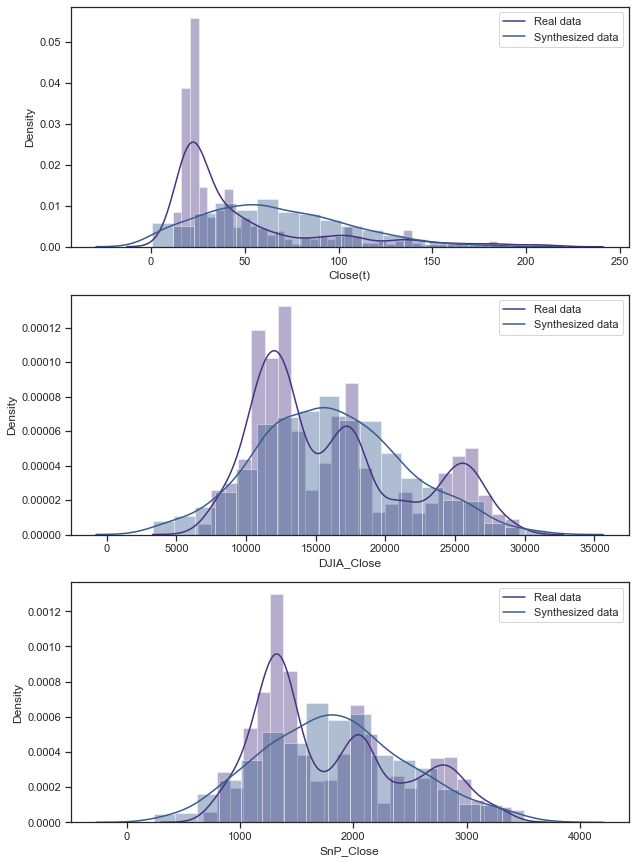

In [288]:
sns.set_theme(style="ticks", palette="viridis")
fix, ax = plt.subplots(3, 1, figsize=(10, 15))

sns.distplot(df['Close(t)'], ax=ax[0])
sns.distplot(synth_df['Close(t)'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['DJIA_Close'], ax=ax[1])
sns.distplot(synth_df['DJIA_Close'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['SnP_Close'], ax=ax[2])
sns.distplot(synth_df['SnP_Close'], ax=ax[2])

ax[2].legend(['Real data', 'Synthesized data'])

## 4.2. Bayes Network (HC algorithm)

In [59]:
data = df[target+predictors]
nodes_type = get_nodes_type(data)
nodes_sign = get_nodes_sign(data)

In [60]:
discrete_data, coder = discretization(data, 'equal_frequency', target+predictors)
b_network = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
b_network

{'V': ['Close(t)',
  'DJIA_Close',
  'SnP_Close',
  'MA10',
  'SD20',
  'MACD',
  'ATR',
  'QQQ_Close',
  'QQQ_MA10',
  'Close_forcast'],
 'E': [['Close(t)', 'Close_forcast'],
  ['Close(t)', 'MA10'],
  ['Close(t)', 'QQQ_Close'],
  ['Close(t)', 'MACD'],
  ['DJIA_Close', 'SnP_Close'],
  ['DJIA_Close', 'MACD'],
  ['SnP_Close', 'ATR'],
  ['SnP_Close', 'MACD'],
  ['MA10', 'ATR'],
  ['MA10', 'SD20'],
  ['MA10', 'Close_forcast'],
  ['MA10', 'MACD'],
  ['MACD', 'SD20'],
  ['ATR', 'SD20'],
  ['ATR', 'MACD'],
  ['QQQ_Close', 'QQQ_MA10'],
  ['QQQ_Close', 'ATR'],
  ['QQQ_MA10', 'DJIA_Close'],
  ['QQQ_MA10', 'SnP_Close'],
  ['QQQ_MA10', 'MA10'],
  ['QQQ_MA10', 'SD20'],
  ['QQQ_MA10', 'MACD'],
  ['Close_forcast', 'DJIA_Close']]}

In [61]:
draw_BN(b_network, nodes_type, 'task3_bn')

In [65]:
params = parameter_learning(data, nodes_type, b_network, 'simple')
save_structure(b_network, 'task3_structure')
skel = read_structure('task3_structure')
save_params(params, 'task3_structure')
params = read_params('task3_structure')
task3_bn = HyBayesianNetwork(skel, params)

In [66]:
synth_df = generate_synthetics(task3_bn, nodes_sign, 'simple', 800)

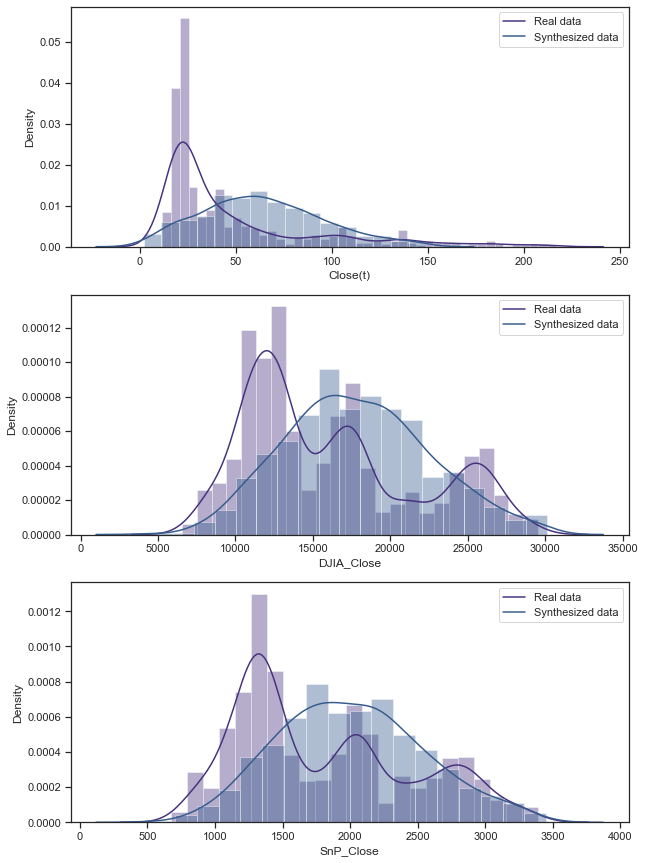

In [67]:
sns.set_theme(style="ticks", palette="viridis")
fix, ax = plt.subplots(3, 1, figsize=(10, 15))

sns.distplot(df['Close(t)'], ax=ax[0])
sns.distplot(synth_df['Close(t)'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['DJIA_Close'], ax=ax[1])
sns.distplot(synth_df['DJIA_Close'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['SnP_Close'], ax=ax[2])
sns.distplot(synth_df['SnP_Close'], ax=ax[2])

ax[2].legend(['Real data', 'Synthesized data'])

In [19]:
print(parall_accuracy(task3_bn, df, target, 'simple', parall_count = 8)[0:2])

({}, {'Close(t)': 9.216, 'DJIA_Close': 577.589, 'SnP_Close': 649.832})


## 4.3. Bayes network (Evo algorithm) 

In [38]:
b_network_evo = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
b_network_evo

Best metric is 11.940699999999998
Generation num: 0
max_depth: 6, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
spent time: 1.7 min
Best metric is 11.5475
Generation num: 1
max_depth: 6, no improvements: 0
spent time: 1.8 min
Best metric is 11.5475
Generation num: 2
max_depth: 6, no improvements: 1
spent time: 1.9 min
Best metric is 10.803999999999998
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 2.0 min
Best metric is 10.803999999999998
Generation num: 4
max_depth: 6, no improvements: 1
spent time: 2.1 min
Best metric is 10.803999999999998
Generation num: 5
max_depth: 6, no improvements: 2
spent time: 2.3 min
Best metric is 10.803999999999998
Generation num: 6
max_depth: 6, no improvements: 3
spent time: 2.3 min
Best metric is 10.803999999999998
Generation num: 7
max_depth: 6, no improvements: 4
spent time: 2.5 min
Best metric is 10.803999999999998
Generation num: 8
max_depth: 6, no improvements: 5
spent t

{'V': ['Close(t)',
  'DJIA_Close',
  'SnP_Close',
  'MA10',
  'SD20',
  'MACD',
  'ATR',
  'QQQ_Close',
  'QQQ_MA10',
  'Close_forcast'],
 'E': [['SD20', 'QQQ_Close'],
  ['DJIA_Close', 'SD20'],
  ['Close(t)', 'SD20'],
  ['MACD', 'QQQ_Close'],
  ['MACD', 'Close(t)'],
  ['MACD', 'SnP_Close'],
  ['SnP_Close', 'Close(t)'],
  ['Close_forcast', 'SnP_Close']]}

In [68]:
draw_BN(b_network_evo, nodes_type, 'task3_bn_evo')

In [69]:
params = parameter_learning(data, nodes_type, b_network_evo, 'mix')
save_structure(b_network_evo, 'task3_evo_structure')
skel = read_structure('task3_evo_structure')
save_params(params, 'task3_evo_structure')
params = read_params('task3_evo_structure')
task3_evo_bn = HyBayesianNetwork(skel, params)

synth_df = generate_synthetics(task3_evo_bn, nodes_sign, 'mix', 800)

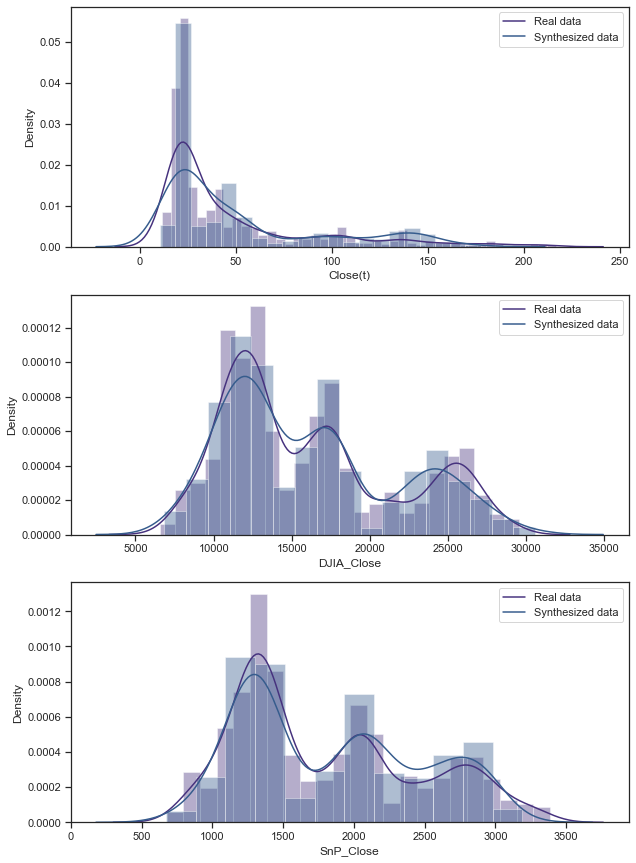

In [70]:
sns.set_theme(style="ticks", palette="viridis")
fix, ax = plt.subplots(3, 1, figsize=(10, 15))

sns.distplot(df['Close(t)'], ax=ax[0])
sns.distplot(synth_df['Close(t)'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['DJIA_Close'], ax=ax[1])
sns.distplot(synth_df['DJIA_Close'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['SnP_Close'], ax=ax[2])
sns.distplot(synth_df['SnP_Close'], ax=ax[2])

ax[2].legend(['Real data', 'Synthesized data'])

In [ ]:
print(parall_accuracy(task3_evo_bn, df, target, 'mix', parall_count = 8)[0:2])